<img align='left' alt='ESO Logo' src='http://archive.eso.org/i/esologo.png'>  

# &nbsp; ESO Science Archive Programmatic: HOWTOs

## HOW TO obtain catalogue data collected with ESO-VISTA 

Catalogues produced by PIs of ESO observing programmes are integrated into the ESO science archive through the [Phase 3 process](https://www.eso.org/sci/observing/phase3.html) and are accessible either via the [ESO Archive Science Portal](https://archive.eso.org/scienceportal/home?dp_type=CATALOG&sort=-obs_date), or via the [Catalog Facility](https://www.eso.org/qi/), or [programmatically](http://archive.eso.org/programmatic/#TAP?e=1) via the `tap_cat` service.

In the following, we will show how to collect catalogue entries associated with the [ESO-VISTA telescope](https://www.eso.org/sci/facilities/paranal/telescopes/vista.html). This will be done by exploiting the `archive_catalogues` module part of the [ESOAsg](https://esoasg.readthedocs.io/en/latest/) `python` repository. This is a wrapper around the [_programmatic access_](http://archive.eso.org/programmatic/#TAP) that allows users to embed [Virtual Observatory Table Access Protocol (TAP)](https://www.ivoa.net/documents/TAP/20190927/) queries within their `python` environment. 

**Usage**: You can access this file as an interactive jupyter notebook, which you can download and run on your machine [(instructions)](https://jupyter.org/install). To interact with the jupyter notebook (if you have download it): move up and down the various cells using the arrow keys, execute the code by pressing CTRL+ENTER; you can also modify the code and execute it at will.

**Version**: Please note that this notebook uses Python version 3.9.13 and Jupyter Notebook version 6.4.10. Compatibility with other versions cannot be guaranteed.

**Authors**: Emanuele Paolo Farina & Ashley Thomas Barnes

In [1]:
from ESOAsg import archive_catalogues # ESO Archive Catalogue

from astropy.coordinates import SkyCoord # Astropy coordinates
import astropy.units as u # Astropy units
import matplotlib.pyplot as plt # Matplotlib
import numpy as np # Numpy
import scipy as sp # Scipy

# Set the default font size and weight for plots
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['figure.dpi'] = 200

---
## <a id='Check catalogue'>1. Check the catalogue you want to query </a>

The full list of available scientific catalogues could be found [here](https://www.eso.org/qi/). Alternatively, this information can retrived by using:
```python
archive_catalogues.all_catalogues_info(all_versions=True)
```
This will return an astropy table of all catalogues (and all their versions). Note that the column `last_version` highlights with `False` and obsolete catalogues for which a newer version is present. 

It is however possible to remove these obsolete versions by setting:
```python
all_version=False # i.e. the default behavior
```

In [2]:
all_catalogues = archive_catalogues.catalogues_info(all_versions=False) # Get all the available catalogues

Now `all_catalogues` contains information on all the latest versions of the catalogues currently present at ESO:

In [3]:
# Show the first 5 rows of the table
all_catalogues['collection', 'table_name', 'title', 'version', 'instrument', 'telescope'].show_in_notebook(show_row_index=False, display_length=5)

collection,table_name,title,version,instrument,telescope
1101.A-0127,AMUSED_MAIN_SOURCE_CAT_V1,AMUSED: the MUSE Hubble Ultra-Deep Field surveys,1,MUSE,ESO-VLT-U4
195.B-0283,GNS_catalogue_V1,GALACTICNUCLEUS Survey,1,HAWKI,ESO-VLT-U4
196.D-0214,EREBOS_RV_cat_fits_V1,EREBOS_RV_cat.fits,1,FORS2,ESO-VLT-U1
196.D-0214,EREBOS_cat_fits_V1,EREBOS_cat.fits,1,FORS2,ESO-VLT-U1
AMBRE,AMBRE_HARPS_V1,Atmospheric Parameters and Chemical Abundances from Stellar Spectra - HARPS,1,HARPS,ESO-3.6
AMBRE,AMBRE_UVES_V1,Atmospheric Parameters and Chemical Abundances from Stellar Spectra - UVES,1,UVES,ESO-VLT-U2
AMBRE,AMBRE_V1,Atmospheric Parameters and Chemical Abundances from Stellar Spectra,1,FEROS,MPI-2.2
ATLASGAL,ATLASGAL_V1,ATLASGAL - APEX Large Area Survey of the Galaxy,1,APEXBOL,APEX-12m
FDS,FDS_SourceCatalogue_V1,Fornax Deep Survey Source Catalogue,1,OMEGACAM,ESO-VST
GAIAESO,GES_2021_VRAD,GAIAESO catalogue of radial velocities,1,MULTI,ESO-VLT-U2


### <a id='Check catalogue'>1.1 Get catalogues </a>

Given that `all_catalogues` is a `Table` you can create a filter based on the `telescope` column. Possible values are:

In [4]:
# Show the number of unique values for the telescope entry
print('Possible values for the telescope entry: \n {}'.format(np.unique(all_catalogues['telescope']).tolist()))

Possible values for the telescope entry: 
 ['', 'APEX-12m', 'ESO-3.6', 'ESO-NTT', 'ESO-VISTA', 'ESO-VLT-U1', 'ESO-VLT-U2', 'ESO-VLT-U2,ESO-VLT-U3', 'ESO-VLT-U3', 'ESO-VLT-U4', 'ESO-VST', 'ESO-VST, ESO-VISTA', 'MPI-2.2', 'MULTI', 'NGTS', 'UT1', 'UT3']


You can now select all the `ESO-VISTA` catalogues applying a filter for 'ESO-VISTA' and 'ESO-VST, ESO-VISTA' to the `all_catalogues` table:

In [5]:
vista_telescope_filter = (all_catalogues['telescope'] == 'ESO-VISTA') | (all_catalogues['telescope'] == 'ESO-VST, ESO-VISTA') # Filter the VISTA catalogues
vista_catalogues = all_catalogues.copy()[vista_telescope_filter] # Get the VISTA catalogues
vista_catalogues['collection', 'table_name', 'title', 'version', 'instrument', 'telescope'].show_in_notebook(show_row_index=False, display_length=5) # Show the first 5 rows of the table

collection,table_name,title,version,instrument,telescope
GCAV,gcav_rxcj1515_YJKs_cat_fits_V1,GCAV catalogue for RXCJ1514.9-1523 cluster,1,VIRCAM,ESO-VISTA
GCAV,gcav_rxcj2129_YJKs_cat_fits_V1,GCAV catalogue for RXCJ2129.6+0005 cluster,1,VIRCAM,ESO-VISTA
KIDS,KiDS_DR4_1_ugriZYJHKs_cat_fits,The Kilo-Degree Survey 9-band ugriZYJHKs source catalogue,4,"OMEGACAM, VIRCAM","ESO-VST, ESO-VISTA"
MW-BULGE-PSFPHOT,MW_BULGE_PSFPHOT_V1,Milky Way Bulge PSF Photometry,1,VIRCAM,ESO-VISTA
UltraVISTA,COSMOS2015_Laigle_v1_1b_latestV7_fits_V1,COSMOS2015 catalogue: photometric redshifts and stellar masses (Laigle et al. 2016),1,VIRCAM,ESO-VISTA
UltraVISTA,COSMOS2020_CLASSIC_V2,COSMOS2020 CLASSIC catalogue: multi-wavelength traditional aperture photometry and photometric redshifts in the COSMOS field,2,VIRCAM,ESO-VISTA
UltraVISTA,COSMOS2020_FARMER_V2,COSMOS2020 FARMER catalogue: multi-wavelength profile fitting photometry and photometric redshift in the COSMOS filed,2,VIRCAM,ESO-VISTA
UltraVISTA,UVISTA_5band_cat_dr6_rc_v1_fits_V5,Deep/Ultra-Deep Near-IR Survey of the COSMOS Field (Ultra-VISTA),5,VIRCAM,ESO-VISTA
VEXAS,VEXAS_AllWISE_V1,VISTA extension to auxilliary surveys - match with AllWISE,1,VIRCAM,ESO-VISTA
VHS,VHS_CAT_V3,VISTA Hemisphere Survey band-merged multi-waveband catalogues (VHS),3,VIRCAM,ESO-VISTA


To obtain the description of the content of each of the selected tables, you can recursively loop over the entries of the `description` column:

In [6]:
for idx in range(len(vista_catalogues)):
    print('Collection:  {} \nTable:       {} \nDescription: {} \n \n'.format(vista_catalogues['collection'][idx],
                                                                       vista_catalogues['table_name'][idx],
                                                                       vista_catalogues['description'][idx]))

Collection:  GCAV 
Table:       gcav_rxcj1515_YJKs_cat_fits_V1 
Description: GCAV YJKs merged catalogue for RXCJ1514.9-1523 cluster, containing aperture matched photometry from the deep stacks 
 

Collection:  GCAV 
Table:       gcav_rxcj2129_YJKs_cat_fits_V1 
Description: GCAV YJKs merged catalogue for RXCJ2129.6+0005 cluster, containing aperture matched photometry from the deep stacks 
 

Collection:  KIDS 
Table:       KiDS_DR4_1_ugriZYJHKs_cat_fits 
Description: The DR4.1 catalogue is an update of the DR4.0 catalogue which, due to a small bug in the alignment of the mask images during the multi-band catalogue production, has incorrect photometry flags for a small percentage of sources on 196 tiles. 
 

Collection:  MW-BULGE-PSFPHOT 
Table:       MW_BULGE_PSFPHOT_V1 
Description: This catalog provides a comprehensive census of the stellar populations in the inner ~300 sqdeg of the Galaxy. It is based on observations obtained with VISTA as part of the ESO public survey VVV. The measu

### <a id='Get RA/Dec'>1.2 Identify RA, Dec (or other properties) in catalogues</a>

Now you are ready the recursively explore all catalogues containing data collected with the [ESO-VISTA telescope](https://www.eso.org/sci/facilities/paranal/telescopes/vista.html). There is however a point that needs to be taken into account first: some catalogues can be spread among different tables. 

This is the case, for instance, of the [VISTA survey of the Magellanic Clouds system (VMC)](https://www.eso.org/rm/api/v1/public/releaseDescriptions/155). 

The reference catalogue that contains position and ID of the sources is identified by the column `target_table`:

In [7]:
vmc_filter = (vista_catalogues['collection'] == 'VMC') # Filter the VMC catalogues
vmc_catalogues = vista_catalogues.copy()[vmc_filter] # Get the VMC catalogues
vmc_catalogues['collection', 'table_name', 'target_table', 'table_RA', 'table_Dec'].show_in_notebook(show_row_index=False, display_length=5) # Show the first 5 rows of the table

collection,table_name,target_table,table_RA,table_Dec
VMC,vmc_dr6_ksjy_V5,,RA2000,DEC2000
VMC,vmc_dr6_mPhotJ_V5,vmc_dr6_ksjy_V5,None,None
VMC,vmc_dr6_mPhotKs_V5,vmc_dr6_ksjy_V5,None,None
VMC,vmc_dr6_mPhotY_V5,vmc_dr6_ksjy_V5,None,None
VMC,vmc_dr6_yjks_psf_V4,vmc_dr6_ksjy_V5,RA2000,DEC2000
VMC,vmc_dr6_yjks_varCat_V2,vmc_dr6_ksjy_V5,None,None
VMC,vmc_er4_yjks_cepheidCatMetaData_fits_V3,vmc_er4_ksjy_catMetaData_fits_V3,RA2000,DEC2000
VMC,vmc_er4_yjks_eclBinCatMetaData_fits_V2,vmc_er4_ksjy_catMetaData_fits_V3,RA2000,DEC2000
VMC,vmc_er4_yjks_rrLyrCatMetaData_fits_V1,vmc_er4_ksjy_catMetaData_fits_V3,RA2000,DEC2000


This basically means, for instance, that basic information on the targets present in the table `vmc_dr6_ksjy_V5` are located in the `target_table`: `vmc_dr6_ksjy_V5`. Thus to find RA and Dec of the sources present in the [VMC](https://www.eso.org/rm/api/v1/public/releaseDescriptions/155) catalogues, you should (in principle) extract columns corresponding to the the `ucd` tokes: `pos.eq.ra;meta.main` and `pos.eq.dec;meta.main` from the `target_table`:

In [8]:
columns_VMC_PhotJ = archive_catalogues.columns_info(tables='vmc_dr6_ksjy_V5') # Get the columns information for the VMC table
columns_VMC_PhotJ[(columns_VMC_PhotJ['ucd'] == 'pos.eq.ra;meta.main') |  # Filter the columns with RA
                  (columns_VMC_PhotJ['ucd'] == 'pos.eq.dec;meta.main')  # Filter the columns with Dec
                  ].show_in_notebook(show_row_index=False) # Show the columns

table_name,column_name,ucd,datatype,description,unit
vmc_dr6_ksjy_V5,RA2000,pos.eq.ra;meta.main,DOUBLE,Celestial Right Ascension,deg
vmc_dr6_ksjy_V5,DEC2000,pos.eq.dec;meta.main,DOUBLE,Celestial Declination,deg


Or equivalently, by extracting from the `vista_catalogues` table entries of the column `table_RA` and `table_Dec` correspoding to the `target_table` = `vmc_dr6_ksjy_V5`:

In [9]:
filter_target_table_vmc = (vmc_catalogues['table_name'] == 'vmc_dr6_ksjy_V5') # Filter the VMC table
column_RA, column_Dec = vmc_catalogues[filter_target_table_vmc]['table_RA'][0], vmc_catalogues[filter_target_table_vmc]['table_Dec'][0]
print('The columns containing RA and Dec in vmc_dr6_ksjy_V5 are:\n{}, {}'.format(column_RA, column_Dec))

The columns containing RA and Dec in vmc_dr6_ksjy_V5 are:
RA2000, DEC2000


### <a id='Explore Catalogues'>1.3 Explore content of the catalogues </a>


In general, one can glance the content of a catalogue by checking the name of the columns present in the associated list of tables (or list of collections). For instance, for the [Kilo Degree Survey](https://www.eso.org/rm/api/v1/public/releaseDescriptions/151) this can be obtained with calling:
```python
archive_catalogues.columns_info(tables='KiDS_DR4_1_ugriZYJHKs_cat_fits')
```

In [10]:
table_kids = 'KiDS_DR4_1_ugriZYJHKs_cat_fits' # Define the KiDS table
columns_kids = archive_catalogues.columns_info(tables=table_kids) # Get the columns information for the KiDS table
columns_kids.show_in_notebook(show_row_index=False, display_length=5) # Show the first 5 rows of the table

table_name,column_name,ucd,datatype,description,unit
KiDS_DR4_1_ugriZYJHKs_cat_fits,ID,meta.id;meta.main,CHAR,ESO ID,
KiDS_DR4_1_ugriZYJHKs_cat_fits,KIDS_TILE,meta.id,CHAR,Name of the pointing in AW convention,
KiDS_DR4_1_ugriZYJHKs_cat_fits,THELI_NAME,meta.id,CHAR,Name of the pointing in THELI convention,
KiDS_DR4_1_ugriZYJHKs_cat_fits,SeqNr,meta.id,INTEGER,Running object number within the catalogue,
KiDS_DR4_1_ugriZYJHKs_cat_fits,SLID,meta.id,INTEGER,AstroWise Source list ID,
KiDS_DR4_1_ugriZYJHKs_cat_fits,SID,meta.id,INTEGER,AstroWise Source ID within the source list,
KiDS_DR4_1_ugriZYJHKs_cat_fits,FLUX_AUTO,phot.flux;em.opt.R,REAL,r-band flux (counts),count
KiDS_DR4_1_ugriZYJHKs_cat_fits,FLUXERR_AUTO,stat.error;phot.flux;em.opt.R,REAL,Error on FLUX_AUTO (counts),count
KiDS_DR4_1_ugriZYJHKs_cat_fits,MAG_AUTO,phot.mag;em.opt.R,REAL,r-band magnitude (mag),mag
KiDS_DR4_1_ugriZYJHKs_cat_fits,MAGERR_AUTO,stat.error;phot.mag;em.opt.R,REAL,Error on MAG_AUTO (mag),mag


Once you decided which columns you want to extract from a given table, you can get it using:
```python
archive_catalogues.get_catalogues(tables=table_name, columns=columns)
```
For instance, to obtain `MAG_AUTO` and `MAGERR_AUTO` from the `KIDS` table (note that for the moment with limit the query to only 5 entries, i.e. we set `maxrec=5`):

In [11]:
columns = [
    'MAG_AUTO', # Magnitude
    'MAGERR_AUTO' #Magnitude error
    ] #Define the columns to retrieve
kids = archive_catalogues.get_catalogues(tables=table_kids, columns=columns, maxrec=5) # Get the first 5 rows of the KiDS table

/Users/abarnes/opt/anaconda3/lib/python3.9/site-packages/pyvo/dal/query.py:322: DALOverflowWarning: Partial result set. Potential causes MAXREC, async storage space, etc.
  warn("Partial result set. Potential causes MAXREC, async storage space, etc.",
[INFO]    :: The query to KiDS_DR4_1_ugriZYJHKs_cat_fits returned 5 entries (with a limit set to maxrec=5)


The result is thus stored in an `astropy.table`:

---

## <a id='Plot Catalogues'>2. Show Location of sources observed with ESO-VISTA </a>


Now it is time to play with the catalogues...  

For instance you can plot the sky location of all sources detected with [ESO-VISTA telescope](https://www.eso.org/sci/facilities/paranal/telescopes/vista.html). 

**Note** that there can be a lot of sources, which can get heavy for both downloading and plotting so we limit the number of rows with `MAXREC` parameter.

In [14]:
MAXREC = 5000000 # We limit the number of retrieved entries 
print(f'The limit of {MAXREC} has been applied.')

The limit of 5000000 has been applied.


[INFO]    :: The query to gcav_rxcj1515_YJKs_cat_fits_V1 returned 138779 entries (with a limit set to maxrec=5000000)
[INFO]    :: The query to gcav_rxcj2129_YJKs_cat_fits_V1 returned 110521 entries (with a limit set to maxrec=5000000)
[INFO]    :: The query to KiDS_DR4_1_ugriZYJHKs_cat_fits returned 5000000 entries (with a limit set to maxrec=5000000)
[INFO]    :: The query to MW_BULGE_PSFPHOT_V1 returned 5000000 entries (with a limit set to maxrec=5000000)
[INFO]    :: The query to COSMOS2015_Laigle_v1_1b_latestV7_fits_V1 returned 1182108 entries (with a limit set to maxrec=5000000)
[INFO]    :: The query to COSMOS2020_CLASSIC_V2 returned 1720700 entries (with a limit set to maxrec=5000000)
[INFO]    :: The query to COSMOS2020_FARMER_V2 returned 964506 entries (with a limit set to maxrec=5000000)
[INFO]    :: The query to UVISTA_5band_cat_dr6_rc_v1_fits_V5 returned 491801 entries (with a limit set to maxrec=5000000)
[INFO]    :: The query to VEXAS_AllWISE_V1 returned 5000000 entries 

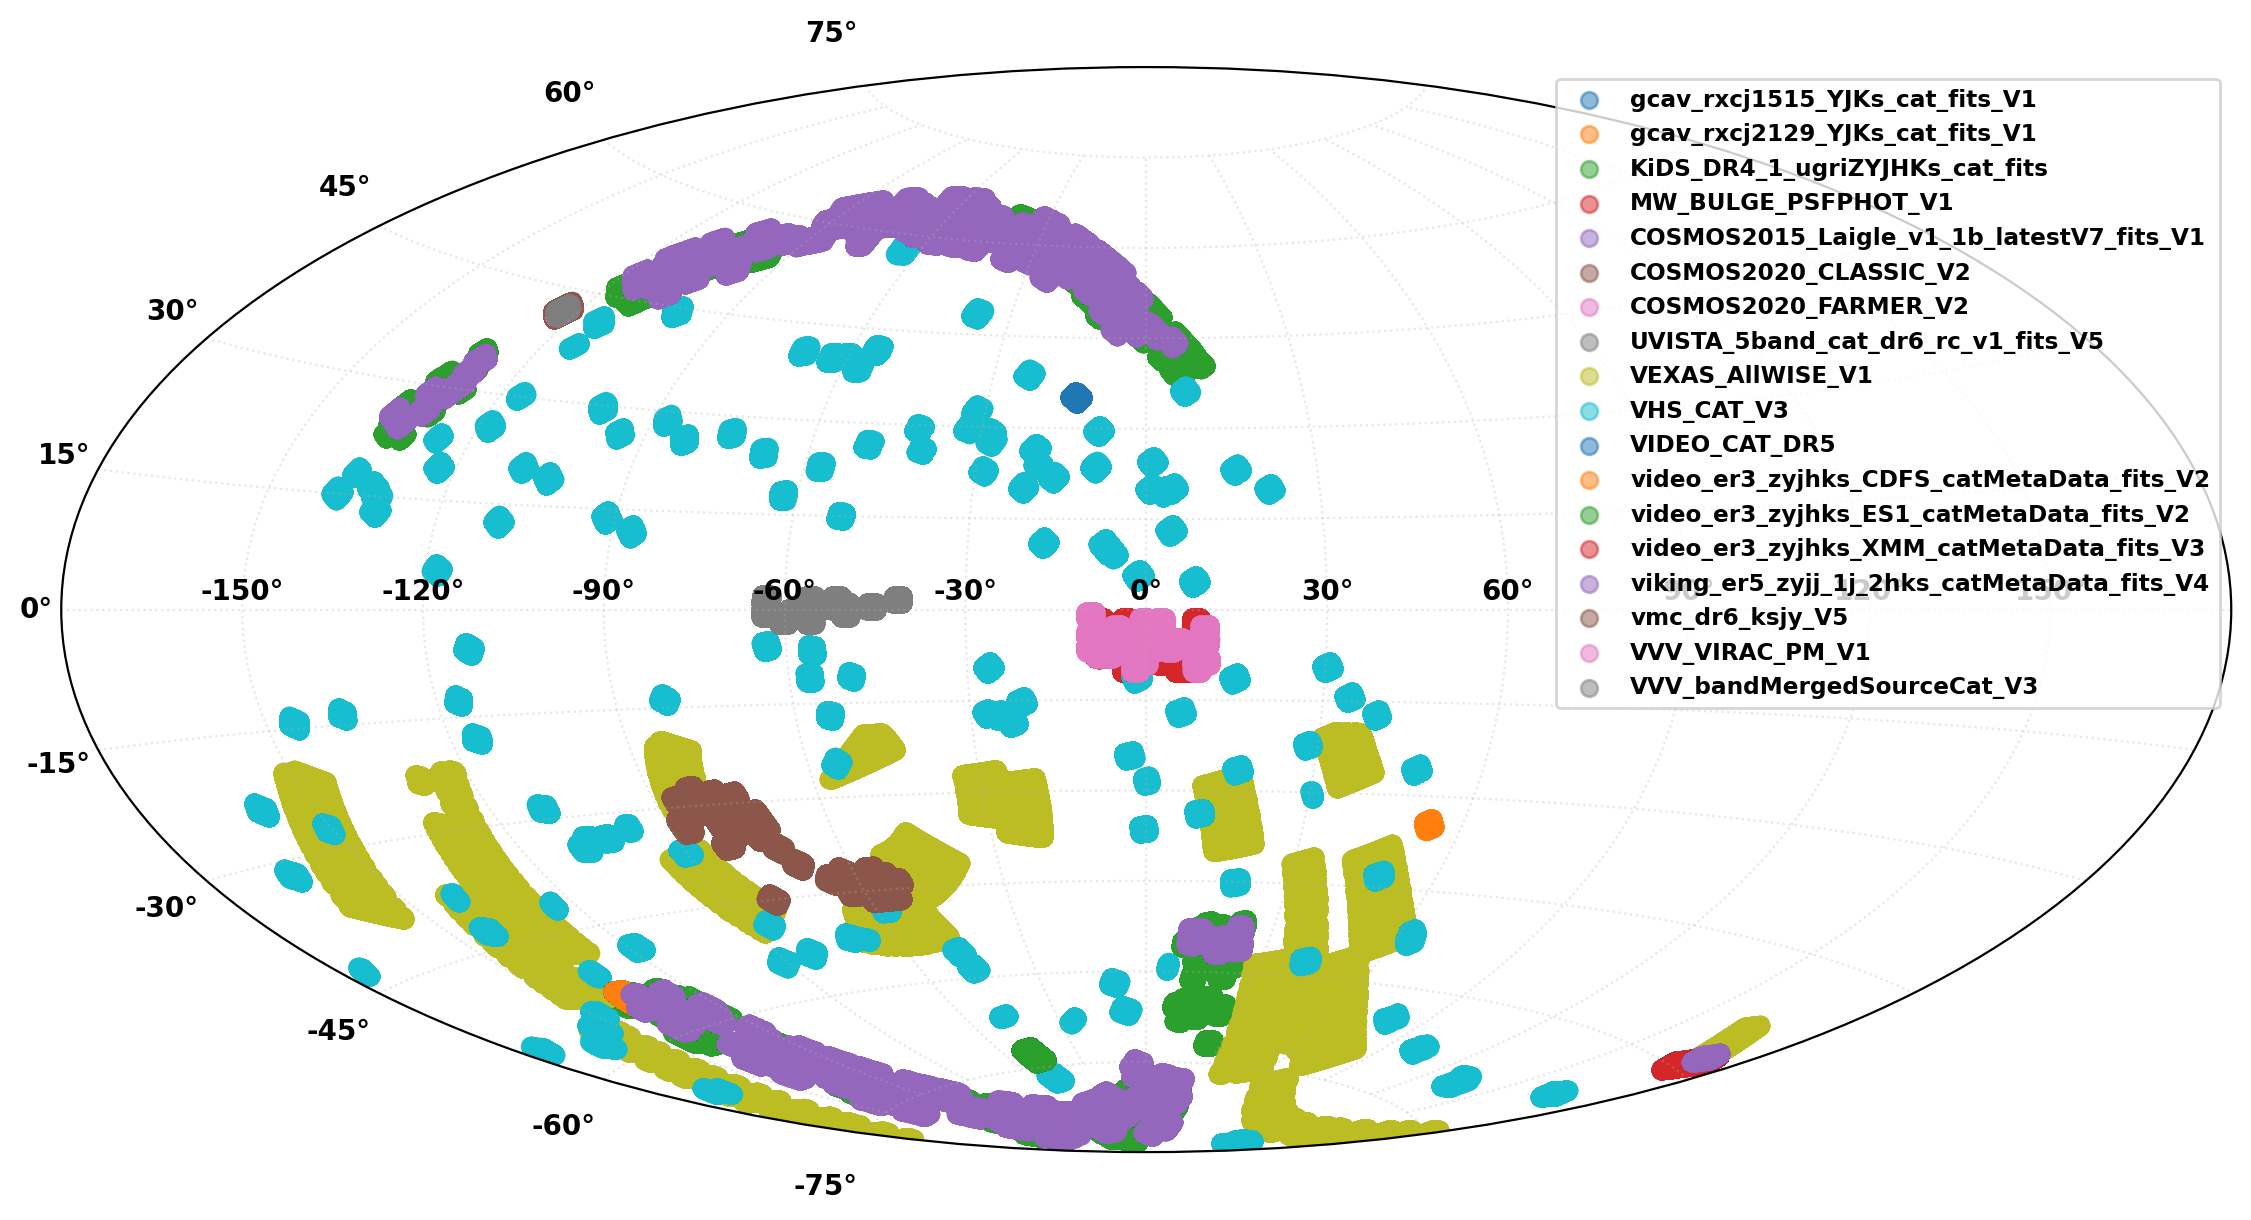

In [15]:
# Create a figure and add a subplot with Aitoff projection for sky mapping
fig = plt.figure(figsize=(14, 10))  # Define the figure size
ax = fig.add_subplot(111, projection='aitoff')  # Add subplot with Aitoff projection

# Iterate through the rows of the `vista_catalogues` dataframe
for idx in range(len(vista_catalogues)):
    table_name = vista_catalogues['table_name'][idx]  # Extract the catalog table name
    target_table = vista_catalogues['target_table'][idx]  # Extract the target table (if any)

    # Proceed only if the target table is not specified (empty string case)
    if target_table == '':
        # Retrieve Right Ascension (RA) and Declination (Dec) column names
        columns = archive_catalogues.columns_info(tables=table_name)  # Get column metadata for the table
        columns_pos = [
            columns['column_name'][(columns['ucd'] == 'pos.eq.ra;meta.main')][0],  # RA column
            columns['column_name'][(columns['ucd'] == 'pos.eq.dec;meta.main')][0]  # Dec column
        ]

        # Query the catalog for RA and Dec positions with a maximum record limit
        positions = archive_catalogues.get_catalogues(
            tables=table_name,  # Table name
            columns=columns_pos,  # Columns to fetch (RA and Dec)
            maxrec=MAXREC  # Maximum number of records to retrieve
        )

        # Ensure RA and Dec values are in degrees; convert if necessary
        if not isinstance(positions[columns_pos[0]].unit, u.core.Unit):  # Check if unit is already defined
            positions[columns_pos[0]].unit = u.deg  # Assign degree unit to RA
            positions[columns_pos[1]].unit = u.deg  # Assign degree unit to Dec

        # Create SkyCoord objects for the positions and convert them to galactic coordinates
        sky_positions = SkyCoord(
            positions[columns_pos[0]].data * positions[columns_pos[0]].unit,  # RA in degrees
            positions[columns_pos[1]].data * positions[columns_pos[1]].unit  # Dec in degrees
        ).galactic  # Convert to galactic coordinates

        # Scatter plot the galactic longitude and latitude on the Aitoff projection
        ax.scatter(
            sky_positions.l.wrap_at('180d').radian,  # Galactic longitude, wrapped at 180 degrees
            sky_positions.b.radian,  # Galactic latitude
            alpha=0.5,  # Set transparency
            label=table_name  # Label for legend
        )

# Add a legend to the plot
ax.legend(fontsize='small', loc='upper right')  # Small font size, legend placed in the upper right corner

# Add a grid for better visualization
ax.grid(True, ls=':', alpha=0.3)  # Dashed grid lines with slight transparency

# Save the plot to a file
fig.savefig('./figures/vista_catalogues.png', format='png', bbox_inches='tight')  # Save as a PNG with tight layout